In [3]:
# !pip install -U langchain-nomic langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python gpt4all firecrawl-py 

In [6]:
import os

# os.environ['LANGCHAIN_TRACKING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

In [1]:
local_llm = 'llama3'

#index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import GPT4AllEmbeddings
from langchain_community.document_loaders import FireCrawlLoader
from langchain_community.vectorstores.utils import filter_complex_metadata
from langchain_community.docstore.document import Document

In [2]:
urls = [

    'https://blog.langchain.dev/agentic-rag-with-langgraph/',
    'https://github.com/openlm-research/open_llama',
]



In [3]:
firecrawlapi = 'fc-5e89b12da8e84278b1fbe6b417a07156'

In [4]:
# fetch documents
docs = [FireCrawlLoader(api_key = firecrawlapi, url = url, mode ='scrape').load() for url in urls]

# flatten list of lists
docs_list = [item for sublist in docs for item in sublist]


# split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 250, chunk_overlap = 0
)

# split documents into chunks
doc_splits = text_splitter.split_documents(docs_list)



In [11]:
# filter out complex metadata


filtered_docs = []
for doc in doc_splits:
    if isinstance(doc, Document) and hasattr(doc, 'metadata'):
        clean_metadata = {k: v for k, v in doc.metadata.items() if isinstance(v, (str,int,float,bool)) }
        filtered_docs.append(Document(page_content = doc.page_content, metadata = clean_metadata))

    else:
        filtered_docs.append(doc)

In [12]:
# add to vectorDB

vectorstore = Chroma.from_documents(
    documents= filtered_docs,
    collection_name = 'rag-chroma',
    embedding= GPT4AllEmbeddings()
)

retriever = vectorstore.as_retriever()


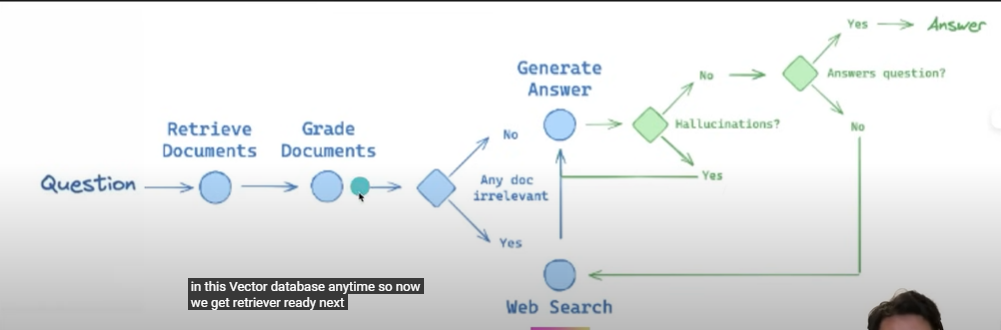

## retrieve documents

In [57]:
# retrieval grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser

## LLM

llm  = ChatOllama(model = local_llm, format = 'json',temperature = 0)

# prompt template

prompt = PromptTemplate(
    template =""" <|begin_of_text/><|start_header_id|>system<|end_header_id> You are a grader assessing relevance of a retrieved document to a 
    user question. If the docuemnt contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is
    to filter out erroneous retrievals. \n Give a binary score 'yes' or 'no' score to indicate whether the documents 
    is relevant to the question. Provide the binary score as a Json with a single key 'score' and no premable or explaination.
    <|eot_id|><|start_header_id|>user<|end_header_id> 
    Here is the retrieved document: \n\n {document}\n\n
    Here is the user question: {question} \n <|eot_id|><|start_header_id|>assistant<|end_header_id|> 
    """,
    input_variables=  ["question", "document"] 
)

# retrieve and grade
retrieval_grader = prompt | llm | JsonOutputParser()
question =  "What is the OpenLLAMA project?"
# question = "What is the BBQ recipe for a good steak?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))    

{'score': 'yes'}


## Generate answer

In [25]:
from langchain_core.output_parsers import StrOutputParser

In [48]:
# prompt template

prompt = PromptTemplate(
    template =""" <|begin_of_text/><|start_header_id|>system<|end_header_id> You are an assistant for question answering tasks. 
    Use the following pieces of retrived context to answer the question. If you dont know the answer, just say that you dont know. \n\n
    Use three sentences maximum and keep the answer concise. <|eot_id|><|start_header_id|>user<|end_header_id> 
    Here is the retrieved document: \n\n {context}\n\n
    Here is the user question: {question} \n 
    <|eot_id|><|start_header_id|>assistant<|end_header_id|> 
    """,
    input_variables=  ["question", "context"] 
)

llm = ChatOllama(model = local_llm, temperature= 0)

def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

#chain
rag_chain = prompt | llm | StrOutputParser()


question = "what is the motivation for self rag?"
docs = retriever.invoke(question)
generation = rag_chain.invoke({"question": question, "context": format_docs(docs)})
print(generation)

The motivation for Self-RAG (Self-Reflective Retrieval and Generation) is to use a Large Language Model (LLM) to self-correct poor quality retrieval and/or generations, allowing for more effective and efficient question answering.


## web search

In [27]:
import os
os.environ["TAVILY_API_KEY"] = "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"


In [28]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k = 5)

In [29]:
# web_search_tool.invoke("OpenLLAMA project")

## Hallucination grader

In [51]:
# Prompt
import time
prompt = PromptTemplate(
    template=""" <|begin_of_text|><|start_header_id|>system<|end_header_id|> You are a grader assessing whether 
    an answer is grounded in / supported by a set of facts. Give a binary 'yes' or 'no' score to indicate 
    whether the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no preamble or explanation. <|eot_id|><|start_header_id|>user<|end_header_id|>
    Here are the facts:
    \n ------- \n
    {documents} 
    \n ------- \n
    Here is the answer: {generation}  <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["generation", "documents"],
)
start = time.time()
hallucination_grader = prompt | llm | JsonOutputParser()
hallucination_grader_response = hallucination_grader.invoke({"documents": docs, "generation": generation})
end = time.time()
print(f"The time required to generate response by the generation chain in seconds:{end - start}")
print(hallucination_grader_response)



The time required to generate response by the generation chain in seconds:8.587991952896118
{'title': 'Self-Reflective RAG with LangGraph', 'score': 5}


In [50]:
# hallucination grader

llm = ChatOllama(model = local_llm, format = 'json',temperature = 0)

prompt = PromptTemplate(
    template =""" <|begin_of_text|><|start_header_id|>system<|end_header_id> You are a grader assessing wheather 
    an answer is grounded in / supported by a set of facts. Give a binary score 'yes' or 'no' score to indicate
    wheather the answer is grounded in / supported by a set of facts. Provide the binary score as a JSON with a 
    single key 'score' and no premable or explaination. <|eot_id|><|start_header_id|>user<|end_header_id|> 
    Here are the facts: 
    \n-----\n 
    {documents}
    \n-----\n
    Here is the answer: {generation} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=  ["generation", "documents"] 
)

hallucination_grader = prompt | llm | JsonOutputParser()

hallucination_grader.invoke({'documents':docs, 'generation': generation})
    

{'grade': 1,
 'feedback': 'The motivation for Self-Reflective RAG (Self-Reflective Retrieval and Generation) is to use a Large Language Model (LLM) to self-correct poor quality retrieval and/or generations, allowing for more effective and efficient question answering.'}

## Answer Grader

In [31]:
# hallucination grader

llm = ChatOllama(model = local_llm, format = 'json',temperature = 0)

prompt = PromptTemplate(
    template =""" <|begin_of_text|><|start_header_id|>system<|end_header_id> You are a grader assessing wheather an answer is useful to resolve a question. 
    Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question. Provide the binary score as a JSON with a single
    key 'score' and no premable or explaination. <|eot_id|><|start_header_id|>user<|end_header_id|> 
    Here are the answer: 
    \n-----\n 
    {generation}
    \n-----\n
    Here is the question: {question} <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=  ["generation", "question"] 
)

answer_grader = prompt | llm | JsonOutputParser()

# answer_grader.invoke({'question':question, 'generation': generation})
    

## Langraph

In [41]:
from typing_extensions import TypedDict
from typing import List, Union


# state

class GraphState(TypedDict):

    """ represets the state 
    
    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        docuements : list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

from langchain.schema import Document

## nodes
def retrieve(state):
    """retrieve documents from vectorstores
    
    Args:
        state (dict): the current graph state
    
    
    Returns:
        state(dict): New key added to state, documents,
        that contains retrieved documents"""
    print('----- Retrieving documents ------')
    question = state['question']

    # retrieval 
    documents = retriever.invoke(question)
    return {'documents':documents, 'question': question}
    
def grade_documents(state):
    """grade documents for relevance
    
    Args:
        state (dict): the current graph state
    
    
    Returns:
        state(dict): New key added to state, documents,
        that contains graded documents"""
    print('----- Grading documents ------')
    question = state['question']
    documents = state['documents']

    # grade documents
    filtered_docs = []
    web_search_value = "No"
    for doc in documents:
        score = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        grade = score['score']
        if grade.lower() == 'yes':
            print('Document is relevant')
            filtered_docs.append(doc)
        else:
            print('Document is irrelevant')
            web_search_value = "Yes"
            continue
    return {'documents':filtered_docs, 'question': question, 'web_search': web_search_value}
    
def generate(state):
    """Generate answer using RAG on retrived documents
    Args:
        state (dict): the current graph state
        
        Returns:
        state(dict): New key added to state, generation,
        that contains generated answer"""
    print('----- Generating answer ------')
    documents = state['documents']
    question = state['question']
    generation = rag_chain.invoke({'context': documents, 'question': question})
    return {'generation': generation, 'documents': documents, 'question': question}


def web_search(state):
    print('----- Web search ------')
    question = state['question']
    documents = state['documents']

    # web search
    docs = web_search_tool.invoke({"query": question})
    web_results ="\n".join([d["content"] for d in docs])
    web_results = Document(page_content = web_results)
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]

    return {'documents':documents, 'question': question}


# conditional edge
def decide_to_generate(state):
    print('----- Deciding whether to web search ------')
    question = state['question']
    filtered_docs = state['documents']
    web_search_value = state['web_search']
    if web_search_value == "Yes":
        print('Web search is needed')
        return 'websearch'
    else:
        print('direct to generation')
        return 'generate'

        
def decide_hallucination(state):
    print('----- Checking hallucination ------')
    generation = state['generation']
    documents = state['documents']
    question = state['question']

    score = hallucination_grader.invoke({"documents": documents, "generation": generation})
    print(score)
    grade = score['score']

    if grade == 'yes':
        print('Generation is relevant')
        
        score  = answer_grader.invoke({"question": question, "generation": generation})
        grade = score['score']
        if grade == 'yes':
            print('Generation is relevant')
            return 'useful'
        else:
            print('Generation is irrelevant')
            return 'not useful'
    else:
        print('Generatoin is not grounded in documents')
        return 'not supported'
    


In [42]:
from langgraph.graph import END, StateGraph


In [43]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("websearch", web_search)  # web search


# Define the edges

workflow.set_entry_point("retrieve") # set entry point
workflow.add_edge('retrieve','grade_documents') # retrieve to grade documents

workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {
        'websearch': 'websearch',
        'generate': 'generate'
    }
) # grade documents to decide to generate
workflow.add_edge("websearch", "generate")
workflow.add_conditional_edges(
    'generate',
    decide_hallucination,
    {
        'not supported': 'generate',
        'useful': END,
        'not useful': "websearch",
    }
) # generate to decide hallucination


# Compile
app = workflow.compile()

In [44]:
app

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<question,generation,web_search,documents>(recurse=True, writes=[ChannelWriteEntry(channel='question', value=<object object at 0x000001EFFD19C040>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='generation', value=<object object at 0x000001EFFD19C040>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='web_search', value=<object object at 0x000001EFFD19C040>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='documents', value=<object object at 0x000001EFFD19C040>, skip_none=False, mapper=_get_state_key(recurse=False))]), ChannelWrite<start:retrieve>(recurse=True, writes=[ChannelWriteEntry(channel='start:retrieve', value='__start__', skip_none=False, mapper=None)])]), 'retrieve': PregelNode(config={'tags': []}, channels={'question':

In [45]:
from pprint import pprint

In [46]:
#
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

----- Retrieving documents ------
'Finished running: retrieve:'
----- Grading documents ------
Document is relevant
Document is relevant
Document is relevant
Document is irrelevant
----- Deciding whether to web search ------
Web search is needed
'Finished running: grade_documents:'
----- Web search ------
'Finished running: websearch:'
----- Generating answer ------
----- Checking hallucination ------
{'type': 'self-reflective rag with langgraph', 'content': "Deep dive into various types of Agent Memory STM: Working memory (LLM Context): It is a data structure with multiple parts which are usually represented with a prompt template and relevant variables. Before runtime, the STM is synthesized by replacing the relevant variables in the prompt template with information retrieved from the LTM.\nHere is a summary of the tokens:\nThis table in the paper supplements the above information:\nWe can outline this as simplified graph to understand the information flow:\nWe can represent this in 

KeyError: 'score'